In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import collections
import ipynb.fs.full.Structural_Perturbations as SP
import ipynb.fs.full.MultiTest as MT
tf.logging.set_verbosity(tf.logging.ERROR)
import sys

/home/uttaran/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Data has apparently already been downloaded and unpacked.


Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
0.76470596


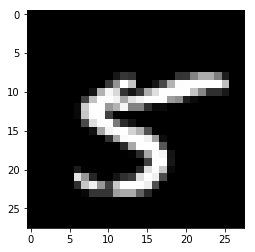

In [2]:
train_data,train_labels,eval_data,eval_labels = SP.load(data='mnist')
SP.Display(eval_data,433)
print(eval_data[1000][433])

In [16]:
eval_data = SP.Scaling(eval_data,.8)

In [18]:
eval_data = Exposure(eval_data,+60)

In [46]:
eval_data = Rotation(eval_data,10)

In [69]:
eval_data = Translation(eval_data,2)

0.76470596


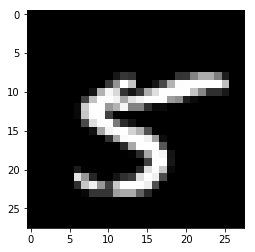

In [3]:
SP.Display(eval_data,433)
print(eval_data[1000][433])
con = []

In [4]:
def cnn_small_model_fn(features, labels, mode):
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=8,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=16,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 16])

    dense = tf.layers.dense(
        inputs=pool2_flat, units=120, activation=tf.nn.relu)

    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    logits = tf.layers.dense(inputs=dropout, units=10)
    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(
            loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(
            mode=mode, loss=loss, train_op=train_op)

    eval_metric_ops = {
        "accuracy":
        tf.metrics.accuracy(labels=labels, predictions=predictions["classes"]),
    }
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [12]:
# Evaluate the model and print results
mnist_classifier_small_1 = tf.estimator.Estimator(
  model_fn=cnn_small_model_fn, model_dir="./models/mnist_convnet_model_small")

mnist_classifier_small_0_8 = tf.estimator.Estimator(
  model_fn=cnn_small_model_fn, model_dir="./models/mnist_convnet_model_small_scale_0.8")

mnist_classifier_small_0_6 = tf.estimator.Estimator(
  model_fn=cnn_small_model_fn, model_dir="./models/mnist_convnet_model_small_scale_0.6")

mnist_classifier_small_0_4= tf.estimator.Estimator(
  model_fn=cnn_small_model_fn, model_dir="./models/mnist_convnet_model_small_scale_0.4")
# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=50)

In [13]:
def current_loss(flag):
    train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      shuffle=False)
    eval_result1=mnist_classifier.evaluate(input_fn=train_eval_input_fn)
    if flag:
        print("%%%%%%% Train accuracy %%%%%%%%%%%%\n",eval_result1)
    [a,b,c] = eval_result1.items()

    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
    eval_result2=mnist_classifier.evaluate(input_fn=eval_input_fn)
    if flag:
        print("######### Test accuracy #############\n",eval_result2)
    [d,e,f] = eval_result2.items()
    return a[1],d[1]

In [14]:
# print("started\n")
# # Train the model
# while 1:
    
# # Train the model
#     print("Training")
#     train_input_fn = tf.estimator.inputs.numpy_input_fn(
#       x={"x": train_data},
#       y=train_labels,
#       batch_size=128,
#       num_epochs=None,
#       shuffle=True)

#     mnist_classifier.train(
#       input_fn=train_input_fn,
#       steps=1000,
#       hooks=[logging_hook])
#     curr_result = current_loss(0)
#     print(curr_result)
#     if curr_result[0] - curr_result[1] > 0.10 or curr_result[1] > 0.98:
#        break
#     #print(curr_result)
    
# print ("Finished")

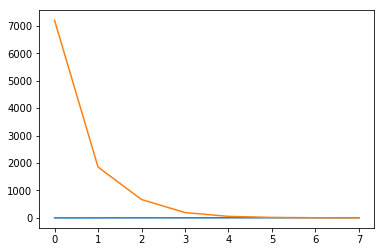

In [9]:
Plot(eval_data,eval_labels,mnist_classifier)

In [18]:
SP.Test(train_data,train_labels,eval_data,eval_labels,mnist_classifier_small_0_4)

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.98210907, 'loss': 0.057732195, 'global_step': 2001}
######### Test accuracy #############
 {'accuracy': 0.9787, 'loss': 0.07314495, 'global_step': 2001}


In [19]:
%%capture
img1,exp1 = MT.scale_test(mnist_classifier=mnist_classifier_small_1,data='mnist')
img2,exp2 = MT.scale_test(mnist_classifier=mnist_classifier_small_0_8,data='mnist')
img3,exp3 = MT.scale_test(mnist_classifier=mnist_classifier_small_0_6,data='mnist')
img4,exp4 = MT.scale_test(mnist_classifier=mnist_classifier_small_0_4,data='mnist')

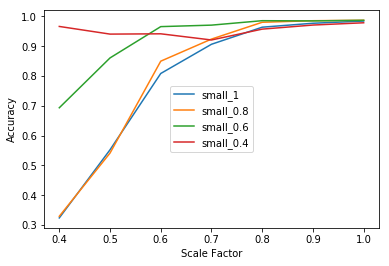

In [20]:
plt.plot(exp1,img1[0])
plt.plot(exp1,img2[0])
plt.plot(exp1,img3[0])
plt.plot(exp1,img4[0])
plt.legend(['small_1', 'small_0.8', 'small_0.6', 'small_0.4'], loc='center')
plt.xlabel("Scale Factor")
plt.ylabel("Accuracy")
plt.show()

In [88]:
%%capture
img1,exp1 = MT.scale_test(mnist_classifier=mnist_classifier_large)
img2,exp2 = MT.scale_test(mnist_classifier=mnist_classifier_small)
img3,exp3 = MT.scale_test(mnist_classifier=mnist_classifier_smaller)

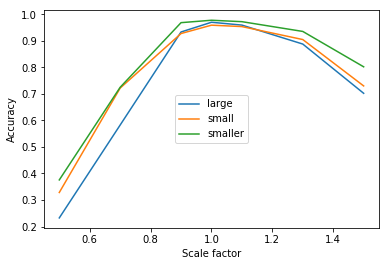

In [89]:
plt.plot(exp1,img1[0])
plt.plot(exp1,img2[0])
plt.plot(exp1,img3[0])
plt.legend(['large', 'small', 'smaller'], loc='center')
plt.xlabel("Scale factor")
plt.ylabel("Accuracy")
plt.show()

In [92]:
%%capture
img1,exp1 = MT.translation_test(mnist_classifier=mnist_classifier_large)
img2,exp2 = MT.translation_test(mnist_classifier=mnist_classifier_small)
img3,exp3 = MT.translation_test(mnist_classifier=mnist_classifier_smaller)

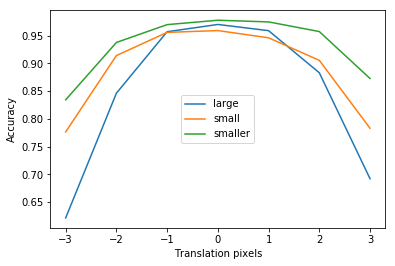

In [93]:
plt.plot(exp1,img1[0])
plt.plot(exp1,img2[0])
plt.plot(exp1,img3[0])
plt.legend(['large', 'small', 'smaller'], loc='center')
plt.xlabel("Translation pixels")
plt.ylabel("Accuracy")
plt.show()

In [73]:
temp.shape

()

In [94]:
temp1,temp2,temp3=[],[],[]
for i in range(0,7):
    temp1.append(np.abs(img1[0][i]-img1[0][3]))
    temp2.append(np.abs(img2[0][i]-img2[0][3]))
    temp3.append(np.abs(img3[0][i]-img3[0][3]))    

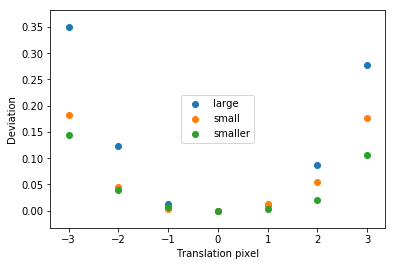

In [95]:
plt.scatter(exp1,temp1)
plt.scatter(exp1,temp2)
plt.scatter(exp1,temp3)
plt.legend(['large', 'small', 'smaller'], loc='center')
plt.xlabel("Translation pixel")
plt.ylabel("Deviation")
plt.show()

In [11]:
grad_cam(mnist_classifier)

NameError: name 'grad_cam' is not defined

In [11]:
t = tf.estimator.Estimator.get_variable_names(mnist_classifier)
print(t)
for i in t: 
    val = tf.estimator.Estimator.get_variable_value(mnist_classifier,name = i)
    print(val.shape)
#     predicted_class = np.argmax(predictions)
#     cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "block5_conv3")

['beta1_power', 'beta2_power', 'conv2d/bias', 'conv2d/bias/Adam', 'conv2d/bias/Adam_1', 'conv2d/kernel', 'conv2d/kernel/Adam', 'conv2d/kernel/Adam_1', 'conv2d_1/bias', 'conv2d_1/bias/Adam', 'conv2d_1/bias/Adam_1', 'conv2d_1/kernel', 'conv2d_1/kernel/Adam', 'conv2d_1/kernel/Adam_1', 'dense/bias', 'dense/bias/Adam', 'dense/bias/Adam_1', 'dense/kernel', 'dense/kernel/Adam', 'dense/kernel/Adam_1', 'dense_1/bias', 'dense_1/bias/Adam', 'dense_1/bias/Adam_1', 'dense_1/kernel', 'dense_1/kernel/Adam', 'dense_1/kernel/Adam_1', 'global_step']
()
()
(8,)
(8,)
(8,)
(5, 5, 1, 8)
(5, 5, 1, 8)
(5, 5, 1, 8)
(16,)
(16,)
(16,)
(5, 5, 8, 16)
(5, 5, 8, 16)
(5, 5, 8, 16)
(120,)
(120,)
(120,)
(784, 120)
(784, 120)
(784, 120)
(10,)
(10,)
(10,)
(120, 10)
(120, 10)
(120, 10)
()


In [12]:
val.shape

()

In [13]:
y = val[:,:,:,0]

IndexError: invalid index to scalar variable.

In [ ]:
y.shape


In [ ]:
t = eval_data[888].reshape(28,28)

In [ ]:
t = t*y